In [1]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
#Import all packages
import pandas as pd
import numpy as np
import math
import random
import os
import cv2
import splitfolders
import matplotlib.pyplot as plt

from sklearn.model_selection import ParameterGrid

import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
splitfolders.ratio("drive/MyDrive/project/Data/images",'drive/MyDrive/project/Data/output',seed=1337,ratio=(0.7,0.15,0.15),group_prefix=None, move=False) 

Copying files: 3280 files [01:08, 47.58 files/s] 


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=[0.5, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest',
    channel_shift_range=10
    )


train_values = train_datagen.flow_from_directory(
    'drive/MyDrive/project/Data/output/train',
    target_size=(224, 224), 
    classes=['baseball', 'basketball', 'fencing', 'tennis','volleyball'],
    batch_size=5,
    class_mode='categorical',
    shuffle=True
)

validation_datagen = ImageDataGenerator()

val_values = validation_datagen.flow_from_directory(
    'drive/MyDrive/project/Data/output/val',
    target_size=(224,224),
    classes=['baseball', 'basketball', 'fencing', 'tennis','volleyball'],
    batch_size=5,
    class_mode='categorical',
    shuffle=True
)

test_datagen=ImageDataGenerator()

test_values=test_datagen.flow_from_directory('drive/MyDrive/project/Data/output/test',
                                             target_size=(224,224),
                                             batch_size=5,
                                             class_mode='categorical',
                                             shuffle=False)

Found 2281 images belonging to 5 classes.
Found 486 images belonging to 5 classes.
Found 495 images belonging to 5 classes.


In [8]:
# Load pre-trained ResNet50 model
resnet_model = ResNet50(include_top=False, input_shape=(224, 224, 3))

# Add new classification layers
model = Sequential()
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

# Freeze pre-trained layers
for layer in resnet_model.layers:
    layer.trainable = False


94765736/94765736 [==============================] - 0s 0us/step


In [9]:
#Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

In [11]:
# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss',verbose=1,patience=10,restore_best_weights=True)

In [12]:
history = model.fit(
    train_values,
    epochs=50,
    validation_data=val_values,
    callbacks=[early_stop]
)

Epoch 1/50
457/457 [==============================] - 78s 137ms/step - loss: 1.8360 - accuracy: 0.2626 - val_loss: 16.4067 - val_accuracy: 0.1646
Epoch 2/50
457/457 [==============================] - 58s 128ms/step - loss: 1.6873 - accuracy: 0.2850 - val_loss: 39.3125 - val_accuracy: 0.1728
Epoch 3/50
457/457 [==============================] - 58s 127ms/step - loss: 1.6131 - accuracy: 0.3021 - val_loss: 44.2738 - val_accuracy: 0.1872
Epoch 4/50
457/457 [==============================] - 58s 128ms/step - loss: 1.5780 - accuracy: 0.3060 - val_loss: 54.8025 - val_accuracy: 0.1975
Epoch 5/50
457/457 [==============================] - 59s 128ms/step - loss: 1.5524 - accuracy: 0.3310 - val_loss: 79.6281 - val_accuracy: 0.1605
Epoch 6/50
457/457 [==============================] - 57s 126ms/step - loss: 1.5273 - accuracy: 0.3384 - val_loss: 104.3413 - val_accuracy: 0.1667
Epoch 7/50
457/457 [==============================] - 57s 126ms/step - loss: 1.5179 - accuracy: 0.3380 - val_loss: 147.0811

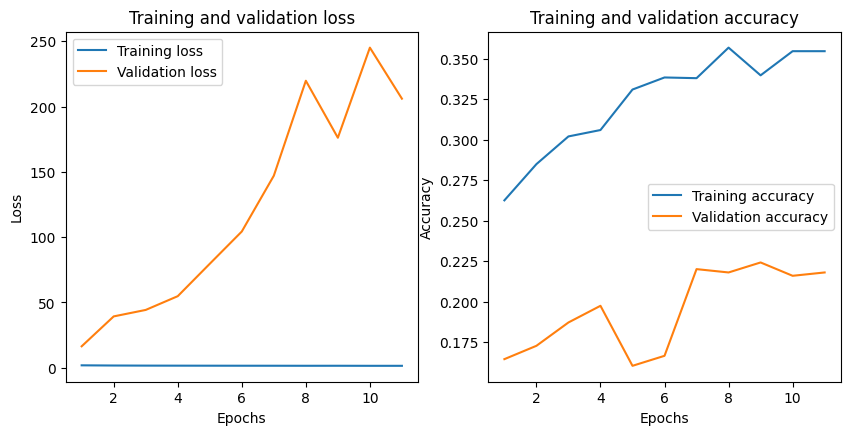

In [13]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
# Get the loss values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

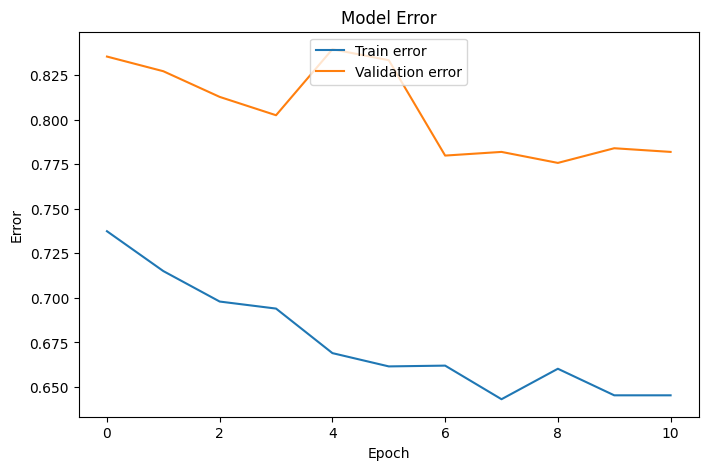

In [14]:
train_accuracy_res=[1-x for x in history.history['accuracy']]
validation_accuracy_res=[1-x for x in history.history['val_accuracy']]

plt.figure(figsize=(8,5))
plt.plot(train_accuracy_res)
plt.plot(validation_accuracy_res)
plt.title('Model Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train error', 'Validation error'], loc='upper center')

In [15]:
# Load pre-trained EfficientNetB0 model
efficientnet_model = EfficientNetB0(include_top=False,input_shape=(224, 224, 3))

#Add new classification layers
model2 = Sequential()
model2.add(efficientnet_model)
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(5, activation='softmax'))

# Freeze pre-trained layers
for layer in efficientnet_model.layers:
    layer.trainable = False
    
# Compile the model
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


In [16]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               16056576  
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                      

In [17]:
# Define early stopping criteria
early_stop2 = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

In [18]:
# Train the model for 50 epochs with early stopping
history2 = model2.fit(train_values, shuffle = True, epochs=100, batch_size = 5, validation_data=val_values, callbacks=[early_stop])

Epoch 1/100
457/457 [==============================] - 68s 127ms/step - loss: 1.9646 - accuracy: 0.2074 - val_loss: 145.1368 - val_accuracy: 0.1276
Epoch 2/100
457/457 [==============================] - 55s 120ms/step - loss: 1.7771 - accuracy: 0.2078 - val_loss: 370.1081 - val_accuracy: 0.2181
Epoch 3/100
457/457 [==============================] - 55s 120ms/step - loss: 1.7188 - accuracy: 0.2174 - val_loss: 523.4438 - val_accuracy: 0.2202
Epoch 4/100
457/457 [==============================] - 55s 120ms/step - loss: 1.7005 - accuracy: 0.2078 - val_loss: 516.4527 - val_accuracy: 0.2202
Epoch 5/100
457/457 [==============================] - 55s 119ms/step - loss: 1.6718 - accuracy: 0.2056 - val_loss: 252.1183 - val_accuracy: 0.2202
Epoch 6/100
457/457 [==============================] - 55s 119ms/step - loss: 1.6620 - accuracy: 0.2074 - val_loss: 703.8635 - val_accuracy: 0.2181
Epoch 7/100
457/457 [==============================] - 55s 120ms/step - loss: 1.6479 - accuracy: 0.2231 - val_lo

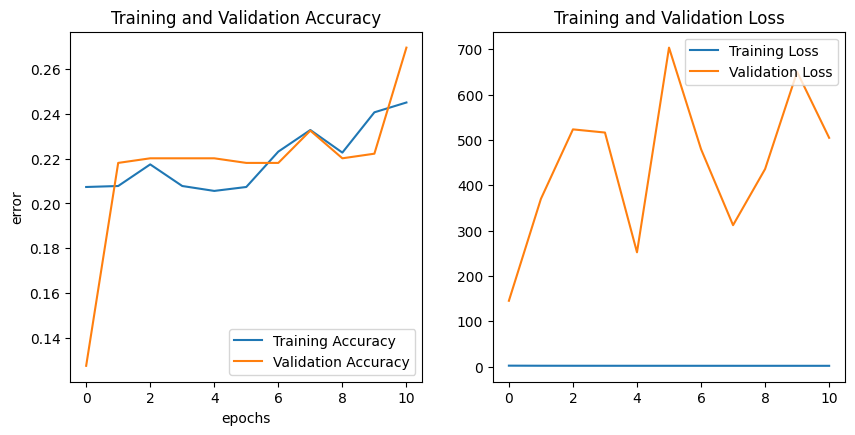

In [19]:
accuracy_effb0 = history2.history['accuracy']
val_accuracy_effb0 = history2.history['val_accuracy']
loss_effb0 = history2.history['loss']
val_loss_effb0 = history2.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(list(range(len(history2.history['accuracy']))), accuracy_effb0, label='Training Accuracy')
plt.plot(list(range(len(history2.history['accuracy']))),val_accuracy_effb0,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel("error")
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(list(range(len(history2.history['accuracy']))), loss_effb0, label='Training Loss')
plt.plot(list(range(len(history2.history['accuracy']))), val_loss_effb0, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

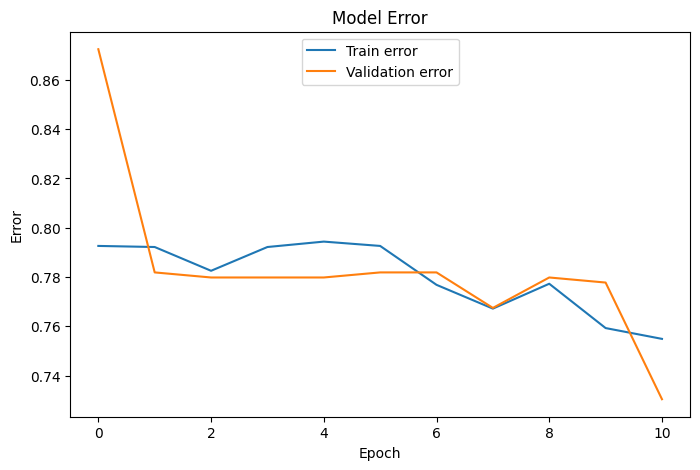

In [20]:
train_accuracy_effb0=[1-x for x in history2.history['accuracy']]
validation_accuracy_effb0=[1-x for x in history2.history['val_accuracy']]

plt.figure(figsize=(8,5))
plt.plot(train_accuracy_effb0)
plt.plot(validation_accuracy_effb0)
plt.title('Model Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train error', 'Validation error'], loc='upper center')

In [21]:
# Load pre-trained VGG16 model
#vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

# Freeze pre-trained layers
for layer in vgg16.layers:
    layer.trainable = False

# Add new classification layers
model3 = Sequential()
model3.add(vgg16)
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(5, activation='softmax'))

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [22]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               6422784   
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                      

In [24]:
# Define early stopping criteria
early_stop3 = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1,restore_best_weights=True )

In [25]:
history3 = model3.fit(
    train_values,
    epochs=50,
    validation_data=val_values,
    callbacks=[early_stop3]
)

Epoch 1/50
457/457 [==============================] - 60s 124ms/step - loss: 1.5081 - accuracy: 0.4261 - val_loss: 1014.8334 - val_accuracy: 0.2942
Epoch 2/50
457/457 [==============================] - 56s 123ms/step - loss: 1.2403 - accuracy: 0.5353 - val_loss: 4854.9814 - val_accuracy: 0.2284
Epoch 3/50
457/457 [==============================] - 56s 123ms/step - loss: 1.1734 - accuracy: 0.5655 - val_loss: 7298.5737 - val_accuracy: 0.2510
Epoch 4/50
457/457 [==============================] - 56s 123ms/step - loss: 1.1655 - accuracy: 0.5765 - val_loss: 12530.7910 - val_accuracy: 0.2407
Epoch 5/50
457/457 [==============================] - 57s 124ms/step - loss: 1.0913 - accuracy: 0.5914 - val_loss: 13613.4697 - val_accuracy: 0.2449
Epoch 6/50
457/457 [==============================] - 57s 124ms/step - loss: 1.1115 - accuracy: 0.5954 - val_loss: 14664.3760 - val_accuracy: 0.2737
Epoch 7/50
457/457 [==============================] - 56s 123ms/step - loss: 1.1389 - accuracy: 0.5804 - val_

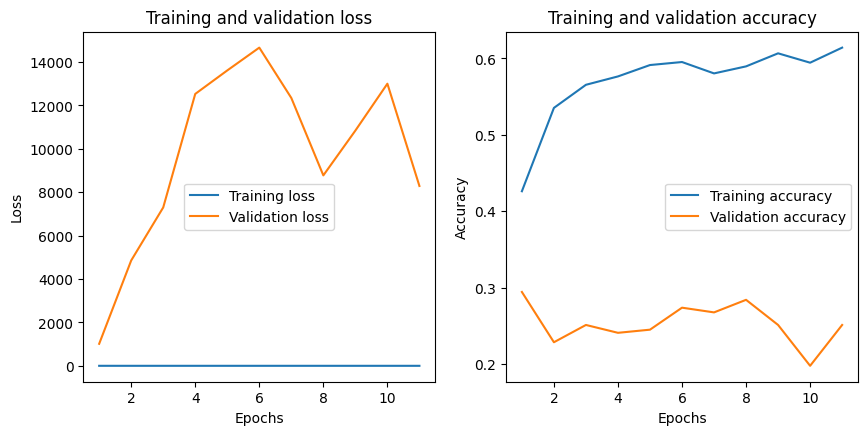

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
# Get the loss values from the history
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Plot the loss values
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

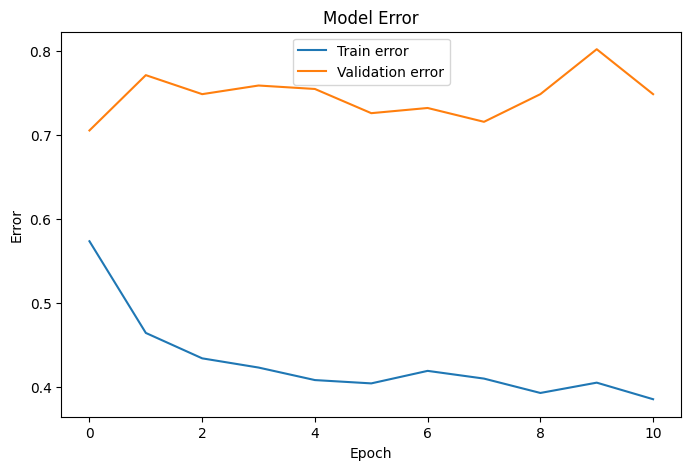

In [27]:
train_accuracy_res=[1-x for x in history3.history['accuracy']]
validation_accuracy_res=[1-x for x in history3.history['val_accuracy']]

plt.figure(figsize=(8,5))
plt.plot(train_accuracy_res)
plt.plot(validation_accuracy_res)
plt.title('Model Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train error', 'Validation error'], loc='upper center')

In [28]:
predict_vgg=model3.predict(test_values,steps=len(test_values))

99/99 [==============================] - 5s 45ms/step


In [29]:
yclass_vgg = predict_vgg.argmax(axis=1)
yclass_vgg

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 4, 0,
       0, 4, 0, 0, 0, 4, 0, 0, 2, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 4, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 4,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 4, 4, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 1, 0, 4, 0, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [30]:
print('Classification Report for EfficientNetB0')
target_names =['Baseball','Basketball', 'Fencing', 'Tennis', 'Volleyball']
print(classification_report(yclass_vgg, test_values.classes, target_names=target_names))

Classification Report for EfficientNetB0
              precision    recall  f1-score   support

    Baseball       0.90      0.26      0.40       385
  Basketball       0.00      0.00      0.00         4
     Fencing       0.00      0.00      0.00         3
      Tennis       0.00      0.00      0.00         2
  Volleyball       0.53      0.56      0.55       101

    accuracy                           0.32       495
   macro avg       0.29      0.16      0.19       495
weighted avg       0.81      0.32      0.43       495



In [33]:
model3.save('drive/MyDrive/project/model.h5')

In [34]:
model_f = load_model('drive/MyDrive/project/model.h5')

In [35]:
videos_path = 'drive/MyDrive/project/Data/videos'
classes = ['BaseballPitch', 'Basketball', 'Fencing', 'TennisSwing', 'VolleyballSpiking']

In [ ]:
# Define L and frame spacing
L = 200
spacing = 5

# Initialize lists for true and predicted labels
y_true = []
y_pred = []

# Define function to preprocess video frames
def preprocess_frame(frame):
    frame = cv2.resize(frame, (224, 224))  # Resize frame to (224, 224)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert frame to RGB
    frame = np.expand_dims(frame, axis=0)  # Add batch dimension
    frame = frame / 255.0  # Normalize pixel values
    return frame

# Loop through videos and calculate average probability vectors
for c in classes:
    class_path = os.path.join(videos_path, c)
    video_files = os.listdir(class_path)
    for video_file in video_files:
        # Open video file
        video_path = os.path.join(class_path, video_file)
        video = cv2.VideoCapture(video_path)

        # Get total number of frames and calculate frame indices
        num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, num_frames-1, num=L, dtype=int)

        # Initialize probability vector and frame counter
        p = np.zeros((1, 5))
        count = 0

        # Loop through frames and calculate probability vectors
        for i in range(num_frames):
            ret, frame = video.read()
            if ret:
                # Preprocess frame and make prediction
                if i in frame_indices:
                    frame = preprocess_frame(frame)
                    p += model.predict(frame)
                    count += 1
            else:
                break

        # Calculate average probability vector
        p_bar = p / count

        # Get predicted class index and label
        predicted_class_index = np.argmax(p_bar)
        predicted_label = classes[predicted_class_index]

        # Print results
        #print(f'{video_file}: Predicted class is {predicted_label}')

        # Append true and predicted labels
        y_true.append(c)
        y_pred.append(predicted_label)

# Calculate evaluation metrics
cm = confusion_matrix(y_true, y_pred, labels=classes)
cr = classification_report(y_true, y_pred, labels=classes)
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, labels=classes, average='weighted')

# Print evaluation metrics
print(f'Confusion Matrix:\n{cm}\n')
print(f'Classification Report:\n{cr}\n')
print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 51s 51s/step
